pipeline:
1.  **Data Cleaning**: Handling missing values.
2.  **Preprocessing**: Ordinal and One-Hot Encoding.
3.  **Splitting**: Stratified train-test split to ensure fair representation.
4.  **Modeling**: Building an OLS Linear Regression model.
5.  **Evaluation**: Checking assumptions and performance metrics.
6.  **Fairness Analysis**: Detecting bias regarding Gender.
7.  **Interpretability**: Using SHAP values.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set visualization style
sns.set_style("whitegrid")

In [2]:
# Load Data
df = pd.read_csv('salary_dataset.csv')

# Handling Missing Values
# Numerical -> Median
for col in ['years_experience', 'performance_score']:
    df[col] = df[col].fillna(df[col].median())

# Categorical -> Mode
for col in ['education_level', 'city']:
    df[col] = df[col].fillna(df[col].mode()[0])

print("Missing values after cleaning:")
print(df.isnull().sum())

Missing values after cleaning:
age                   0
gender                0
education_level       0
years_experience      0
job_title             0
performance_score     0
industry              0
city                  0
previous_companies    0
remote_worker         0
salary                0
dtype: int64


In [3]:
# Ordinal Encoding for Education
edu_map = {'HighSchool': 0, 'Bachelors': 1, 'Masters': 2, 'PhD': 3}
df['education_level_encoded'] = df['education_level'].map(edu_map)

# One-Hot Encoding for other categoricals
# We keep 'gender' in the original dataframe for later analysis, but encode it for the model
categorical_cols = ['job_title', 'industry', 'city', 'remote_worker', 'gender']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Define Features (X) and Target (y)
# Drop original non-numeric columns and the target
X = df_encoded.drop(columns=['salary', 'education_level'])
y = df['salary']

print("Shape of Feature Matrix:", X.shape)

Shape of Feature Matrix: (12000, 36)


In [4]:
# Stratified Split
# We use the original 'gender' column from 'df' for the stratification labels
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=df['gender']
)

print(f"Training Samples: {len(X_train)}")
print(f"Testing Samples: {len(X_test)}")

Training Samples: 9600
Testing Samples: 2400


In [5]:
# Add constant for the intercept term (beta_0)
X_train_const = sm.add_constant(X_train.astype(float))
X_test_const = sm.add_constant(X_test.astype(float))

# Fit Model
model = sm.OLS(y_train, X_train_const).fit()

# Print Summary (Coefficients, P-values, R-squared)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     537.5
Date:                Mon, 22 Dec 2025   Prob (F-statistic):               0.00
Time:                        03:02:53   Log-Likelihood:            -1.0660e+05
No. Observations:                9600   AIC:                         2.133e+05
Df Residuals:                    9563   BIC:                         2.135e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    3

RMSE: 17,905.39
MAE:  7,585.08
R2 Score: 0.6289


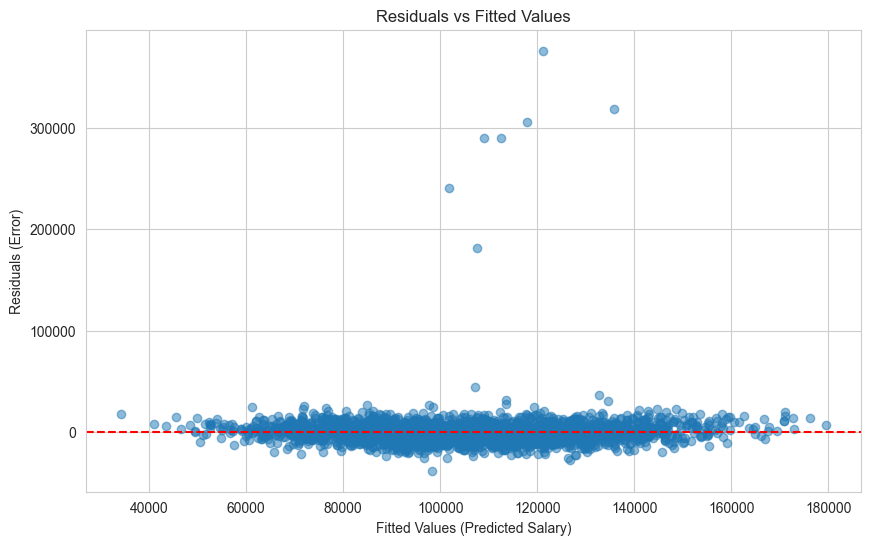

In [6]:
# Predictions
y_pred = model.predict(X_test_const)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:,.2f}")
print(f"MAE:  {mae:,.2f}")
print(f"R2 Score: {r2:.4f}")

# Residual Plot
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values (Predicted Salary)')
plt.ylabel('Residuals (Error)')
plt.title('Residuals vs Fitted Values')
plt.show()

In [7]:
# Prepare Fairness DataFrame
# Recover gender labels using the index
test_gender = df.loc[X_test.index, 'gender']

fairness_df = pd.DataFrame({
    'Gender': test_gender,
    'Actual': y_test,
    'Predicted': y_pred,
    'Residual': residuals
})

# (a) Mean Predictions
print("Mean Predicted Salary by Gender:")
print(fairness_df.groupby('Gender')['Predicted'].mean())

# (b) MAE by Group
print("\nMean Absolute Error by Gender:")
print(fairness_df.groupby('Gender').apply(lambda x: mean_absolute_error(x['Actual'], x['Predicted']), include_groups=False))

# --- Classification Fairness (Threshold > Median) ---
threshold = df['salary'].median()
fairness_df['HighSalary_Pred'] = (fairness_df['Predicted'] > threshold).astype(int)
fairness_df['HighSalary_Actual'] = (fairness_df['Actual'] > threshold).astype(int)

# Calculate Selection Rates
sel_rates = fairness_df.groupby('Gender')['HighSalary_Pred'].mean()
print("\nSelection Rates (Prob. of predicting High Salary):")
print(sel_rates)

# Disparate Impact Ratio (Female / Male)
dir_val = sel_rates['Female'] / sel_rates['Male']
print(f"\nDisparate Impact Ratio (Female/Male): {dir_val:.4f}")
print("(Values < 0.8 typically indicate adverse impact)")

# --- Residual T-Test ---
male_res = fairness_df[fairness_df['Gender'] == 'Male']['Residual']
female_res = fairness_df[fairness_df['Gender'] == 'Female']['Residual']

t_stat, p_val = stats.ttest_ind(male_res, female_res)
print(f"\nT-Test on Residuals (Male vs Female): p-value = {p_val:.4f}")
if p_val < 0.05:
    print("Significant difference in errors between groups (Bias detected in error distribution).")
else:
    print("No significant difference in errors (Model is statistically calibrated).")

Mean Predicted Salary by Gender:
Gender
Female    102457.307423
Male      108323.121836
Other      99995.066247
Name: Predicted, dtype: float64

Mean Absolute Error by Gender:
Gender
Female    7548.387530
Male      7643.392865
Other     6640.184087
dtype: float64

Selection Rates (Prob. of predicting High Salary):
Gender
Female    0.467125
Male      0.584454
Other     0.418605
Name: HighSalary_Pred, dtype: float64

Disparate Impact Ratio (Female/Male): 0.7992
(Values < 0.8 typically indicate adverse impact)

T-Test on Residuals (Male vs Female): p-value = 0.7187
No significant difference in errors (Model is statistically calibrated).
